<a href="https://colab.research.google.com/github/BoogeunSong/song/blob/main/diet_%ED%94%BC%EC%B2%98%EC%84%A0%EC%A0%95%2Bmodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전처리 데이터 프레임 불러오기

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from scipy import stats

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font',family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/diet_Preprocessing.xlsx")
df

,index,age,sex,height,weight,married,want_diet,bmi,pclass,Disease_status,Diet_experience,student,housewife,etc,officeworker,forwhat,resister_month,weight_loss_goal
0,0,26,1,170.0,62.0,0,61.0,21,3,0,1,0,0,0,1,0,12,1.0
1,1,26,2,150.0,50.0,1,47.0,22,2,1,0,0,1,0,0,0,5,3.0
2,2,23,2,165.0,51.0,0,48.0,18,2,1,1,0,0,0,1,0,12,3.0
3,3,22,2,155.0,84.0,0,48.0,30,2,0,1,1,0,0,0,0,2,36.0
4,4,21,2,164.0,58.0,0,48.0,21,3,1,1,1,0,0,0,1,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277,3291,19,2,162.0,57.0,0,50.0,21,2,0,1,1,0,0,0,1,0,7.0
3278,3292,15,1,175.0,72.0,0,68.0,23,2,0,0,1,0,0,0,0,0,4.0
3279,3293,26,2,164.0,57.0,0,52.0,21,1,1,1,0,0,0,1,1,14,5.0
3280,3294,15,2,147.0,42.0,0,39.0,19,2,0,1,1,0,0,0,1,0,3.0


In [ ]:
# pclass를 식품을 1 / 그 외를 0으로 바꿈
def func_pclass(x):
    if (x == 0) | (x == 2)| (x == 3):
        return 0
    else:
        return 1

df["class"] =df["pclass"].map(func_pclass)

In [ ]:
df = df.drop(['index','pclass'], axis = 1)
df.columns

Index(['age', 'sex', 'height', 'weight', 'married', 'want_diet', 'bmi',
       'Disease_status', 'Diet_experience', 'student', 'housewife', 'etc',
       'officeworker', 'forwhat', 'resister_month', 'weight_loss_goal',
       'class'],
      dtype='object')

## Feature Selection

stepwise

In [ ]:
import statsmodels.api as sm
import pandas as pd


# 종속 변수와 독립 변수를 나누기
y = df['class']
X = df.drop(['class'], axis=1)

# Stepwise regression 모델 생성
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # 추가할 변수 찾기
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # 제거할 변수 찾기
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmin()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)
print('Resulting features:')
print(result)

<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  student                        with p-value 3.42212e-10
Add  bmi                            with p-value 0.000528588


<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sex                            with p-value 0.000119565
Add  Diet_experience                with p-value 0.00823706


<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  age                            with p-value 0.00765046
Add  housewife                      with p-value 0.000372274
Resulting features:
['student', 'bmi', 'sex', 'Diet_experience', 'age', 'housewife']


<ipython-input-10-596a32336795>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [ ]:
print(df[result])

      student  bmi  sex  Diet_experience  age  housewife
0           0   21    1                1   26          0
1           0   22    2                0   26          1
2           0   18    2                1   23          0
3           1   30    2                1   22          0
4           1   21    2                1   21          0
...       ...  ...  ...              ...  ...        ...
3277        1   21    2                1   19          0
3278        1   23    1                0   15          0
3279        0   21    2                1   26          0
3280        1   19    2                1   15          0
3281        0   25    2                0   22          1

[3282 rows x 6 columns]


kbest

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# 입력과 출력 변수 분리
X = df.drop("class", axis = 1)
y = df["class"]

# SelectKBest 객체 생성
kbest = SelectKBest(score_func=f_regression, k = 9)

# SelectKBest 적용
X_kbest = kbest.fit_transform(X, y)

# 선택된 feature의 인덱스 확인
print(kbest.get_support(indices = True))

[ 0  1  2  4  6  8  9 12 13]


In [ ]:
# 입력과 출력 변수 분리
X = df.drop("class", axis = 1)
y = df["class"]

# SelectKBest 객체 생성
kbest = SelectKBest(score_func=f_regression, k = 9)

# SelectKBest 적용
X_kbest = kbest.fit_transform(X, y)

# 선택된 feature의 인덱스 확인
selected_indices = kbest.get_support(indices=True)

# 선택된 feature들의 컬럼명 추출
selected_colnames = X.columns[selected_indices]

# 출력
print(selected_colnames)

Index(['age', 'sex', 'height', 'married', 'bmi', 'Diet_experience', 'student',
       'officeworker', 'forwhat'],
      dtype='object')


In [ ]:
a = pd.DataFrame(kbest.get_support(indices = True))
a["name"] = selected_colnames
a

,0,name
0,0,age
1,1,sex
2,2,height
3,4,married
4,6,bmi
5,8,Diet_experience
6,9,student
7,12,officeworker
8,13,forwhat


Lasso

In [ ]:
from sklearn.linear_model import Lasso

# 입력과 출력 변수 분리
X = df.drop("class", axis = 1)
y = df["class"]

# Lasso 객체 생성
lasso = Lasso(alpha = 0.01)

# Lasso 적용
lasso.fit(X, y)

# 선택된 feature의 인덱스 확인
print(lasso.coef_)
print(lasso.feature_names_in_)

[ 5.21898039e-03  0.00000000e+00 -2.07081436e-03  3.17329895e-04
 -0.00000000e+00 -0.00000000e+00  4.08006563e-03  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  7.11879136e-05 -0.00000000e+00  0.00000000e+00  1.10920176e-03]
['age' 'sex' 'height' 'weight' 'married' 'want_diet' 'bmi'
 'Disease_status' 'Diet_experience' 'student' 'housewife' 'etc'
 'officeworker' 'forwhat' 'resister_month' 'weight_loss_goal']


In [ ]:
b = pd.DataFrame(lasso.coef_)
b["name"] = lasso.feature_names_in_
b

,0,name
0,0.005219,age
1,0.000000,sex
2,-0.002071,height
3,0.000317,weight
4,-0.000000,married
5,-0.000000,want_diet
6,0.004080,bmi
7,0.000000,Disease_status
8,0.000000,Diet_experience
9,-0.000000,student


In [ ]:
# Kbest 
#from sklearn.feature_selection import SelectKBest, chi2
#import pandas as pd
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression

# 입력과 출력 변수 분리
#X = df.drop("class", axis = 1)
#y = df["class"]

# SelectKBest 객체 생성
#kbest = SelectKBest(score_func=f_regression, k = 9)

# SelectKBest 적용
#X_kbest = kbest.fit_transform(X, y)

# 선택된 feature의 인덱스 확인
#print(kbest.get_support(indices = True))

In [ ]:
#from sklearn.feature_selection import SelectKBest, f_regression

# 입력과 출력 변수 분리
#X = df.drop("class", axis = 1)
#y = df["class"]

# SelectKBest 객체 생성
#kbest = SelectKBest(score_func=f_regression, k = 9)

# SelectKBest 적용
#X_kbest = kbest.fit_transform(X, y)

# 선택된 feature의 인덱스 확인
#selected_indices = kbest.get_support(indices=True)

# 선택된 feature들의 컬럼명 추출
#selected_colnames = X.columns[selected_indices]

# 출력
#print(selected_colnames)

In [ ]:
# Stepwise
#import statsmodels.api as sm
#import pandas as pd


# 종속 변수와 독립 변수를 나누기
#y = df['class']
#X = df.drop(['class'], axis=1)

# Stepwise regression 모델 생성
#def stepwise_selection(X, y, 
#                       initial_list=[], 
#                       threshold_in=0.01, 
#                       threshold_out = 0.05, 
#                       verbose=True):
#    included = list(initial_list)
#    while True:
#        changed = False
#        # 추가할 변수 찾기
#        excluded = list(set(X.columns)-set(included))
#        new_pval = pd.Series(index=excluded)
#        for new_column in excluded:
#            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
#            new_pval[new_column] = model.pvalues[new_column]
#        best_pval = new_pval.min()
#        if best_pval < threshold_in:
#            best_feature = new_pval.idxmin()
#            included.append(best_feature)
#            changed = True
#            if verbose:
#                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
#
#        # 제거할 변수 찾기
#        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
#        pvalues = model.pvalues.iloc[1:]
#        worst_pval = pvalues.max()
#        if worst_pval > threshold_out:
#            changed = True
#            worst_feature = pvalues.idxmin()
#            included.remove(worst_feature)
#            if verbose:
#                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
#        if not changed:
#            break
#    return included

#result = stepwise_selection(X, y)
#print('Resulting features:')
#print(result)

In [ ]:
# Lasso
#from sklearn.linear_model import Lasso

# 입력과 출력 변수 분리
#X = df.drop("class", axis = 1)
#y = df["class"]

# Lasso 객체 생성
#lasso = Lasso(alpha = 0.01)

# Lasso 적용
#lasso.fit(X, y)

# 선택된 feature의 인덱스 확인
#print(lasso.coef_)
#print(lasso.feature_names_in_)

In [ ]:
#a = pd.DataFrame(lasso.coef_)
#a["name"] = lasso.feature_names_in_
#a

위 세가지 방법을 통해 [age/ Sex/ Height/ weight/ Officeworker/ want_diet/ weight_loss_goal/ student]의 8가지 항목 지정

In [ ]:
#df.columns

In [ ]:
#df = df.drop(['weight', 'married', 'want_diet', 'bmi', 'Disease_status', 'Diet_experience',
#              'housewife', 'etc', 'forwhat', 'resister_month'], axis=1)

## Data Frame 재조립

[age/ Sex/ Height/ weight/ Officeworker/ want_diet/ weight_loss_goal/ student]

In [ ]:
df = df.drop(['weight','want_diet','Disease_status','etc','resister_month','weight_loss_goal'], axis=1)
df.columns

Index(['age', 'sex', 'height', 'married', 'bmi', 'Diet_experience', 'student',
       'housewife', 'officeworker', 'forwhat', 'class'],
      dtype='object')

## 변수 상관성

/usr/local/lib/python3.9/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


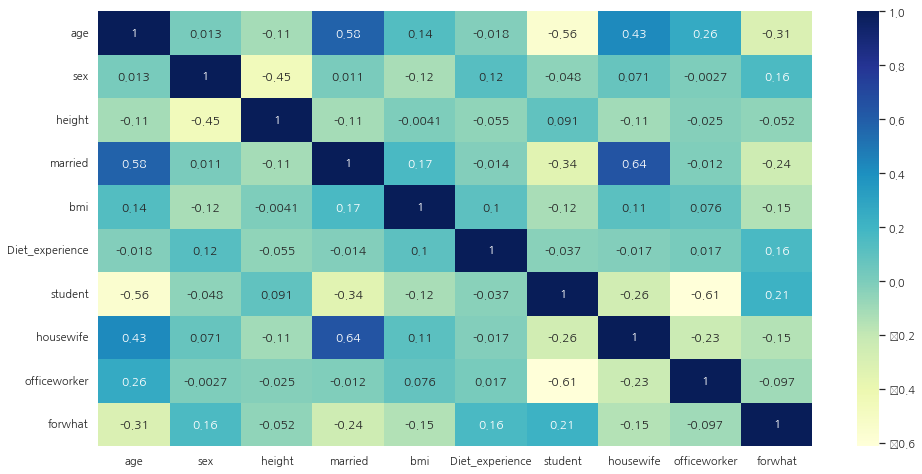

In [ ]:
# 1) 독립변수, 종속변수 설정
y = df[['class']]
#x = df[['age','occupation','married','diet_purpose','bmi','p_quantity','질병유무','경험','p_price']]
x = df.drop('class',axis=1)
# 2)상관행렬 보기
x.corr()

# 3) 상관행렬 시각화
cmap = sns.light_palette("darkgray", as_cmap = True)
sns.set(font="NanumGothic",rc = {'figure.figsize':(16,8)})  
sns.heatmap(x.corr(), annot=True, cmap="YlGnBu")
plt.show()

# 4) 변수끼리 산점도를 시각화
#sns.pairplot(x)
#plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = x
# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor", ascending=False)


# 결과 출력
vif=pd.DataFrame(vif)
vif

,VIF Factor,features
2,122.928079,height
1,59.388552,sex
4,52.058455,bmi
0,33.681911,age
5,4.384195,Diet_experience
6,4.214544,student
8,3.326946,officeworker
9,2.987631,forwhat
3,2.597949,married
7,2.347252,housewife


In [ ]:
y = df[['class']]
x = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]

In [ ]:
X = x
# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor", ascending=False)


# 결과 출력
vif=pd.DataFrame(vif)
vif

,VIF Factor,features
0,8.344812,age
1,3.993599,Diet_experience
3,3.104507,officeworker
2,2.862990,student
4,2.671528,forwhat
5,2.433504,married
6,2.319692,housewife


## Grid Search

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
df.isnull().sum()

age                0
sex                0
height             0
married            0
bmi                0
Diet_experience    0
student            0
housewife          0
officeworker       0
forwhat            0
class              0
dtype: int64

In [ ]:
df.columns

Index(['age', 'sex', 'height', 'married', 'bmi', 'Diet_experience', 'student',
       'housewife', 'officeworker', 'forwhat', 'class'],
      dtype='object')

In [ ]:
Y.value_counts()

class
0        2819
1         463
dtype: int64

In [ ]:
#필요열(변수,feature)만 뽑아서 데이터 만들기
Y = df[['class']]
X = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]
#데이터분할 (train,test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

#model 만들기
model = KNeighborsClassifier()

#검증
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
scores = cross_val_score(model, X_train, Y_train, cv = skf)
print("교차검증점수:", scores)

교차검증점수: [0.85       0.83913043 0.82352941 0.83877996 0.82135076]


/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [ ]:
#격자:grid
from sklearn.model_selection import GridSearchCV

#데이터 분할(train, test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#모형생성
model = KNeighborsClassifier()

#그리드 인자 검색
mylist = list(range(1,50))
k_list = [x for x in mylist if x %2 !=0]
parameter_grid = {"n_neighbors" : k_list}

#Grid Search

grid_search=GridSearchCV(model,parameter_grid,cv=10)
grid_search.fit(X_train,Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]})

In [ ]:
#cv가 정해준 값에서 최적의 값?ㅋ
grid_search.best_params_

{'n_neighbors': 23}

In [ ]:
#결과
grid_search.cv_results_

{'mean_fit_time': array([0.00509384, 0.00540481, 0.00585384, 0.00507779, 0.00510595,
        0.00514095, 0.0049952 , 0.00492921, 0.00506895, 0.00483658,
        0.0050858 , 0.00502343, 0.00556598, 0.00516515, 0.00470493,
        0.00548463, 0.00517929, 0.00546815, 0.00559096, 0.00501204,
        0.00509102, 0.00499425, 0.00534787, 0.00485127, 0.00507963]),
 'std_fit_time': array([0.00073157, 0.00121242, 0.00233755, 0.00066361, 0.0006411 ,
        0.00074461, 0.00094608, 0.00023807, 0.00089786, 0.00021797,
        0.0006141 , 0.00066008, 0.00138439, 0.00090528, 0.00015391,
        0.00145263, 0.00074333, 0.00173878, 0.0018991 , 0.00071205,
        0.00080394, 0.00063369, 0.0008381 , 0.00045011, 0.00094347]),
 'mean_score_time': array([0.01302297, 0.01190104, 0.0112318 , 0.01346366, 0.01398249,
        0.01291506, 0.01239183, 0.01242409, 0.01285105, 0.01415591,
        0.01370046, 0.01432481, 0.01433694, 0.0124337 , 0.01323068,
        0.01340811, 0.01492343, 0.01311553, 0.01280482, 0.01

In [ ]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=23)

In [ ]:
# X_test를 최적의 추정치/식(Be)으로 예측치(predict): Y^를 도출
# 도출해낸 Y^와 Y_test를 비교

from sklearn.metrics import accuracy_score
be=grid_search.best_estimator_
pred=be.predict(X_test) #
accuracy_score(Y_test,pred)

0.8538071065989847

## 오버샘플링

In [ ]:
#오버 샘플링
from imblearn.over_sampling import SMOTE #Synthetic Minority Over-sampling Technique
from collections import Counter

X_train_over, Y_train_over = SMOTE(random_state=0).fit_resample(X_train,Y_train)

print("original data %s" %Counter(Y)) #original data 1000개 중에서 이탈여부 1 (이탈함)또는 0값(이탈안함) 700개와 300개 도출
print("original train data %s" %Counter(Y_train)) #대략 70%정도의 데이터 0은481개 1은 219개 데이터를 도출
print("over train data %s" %Counter(Y_train_over))

original data Counter({'class': 1})
original train data Counter({'class': 1})
over train data Counter({'class': 1})


In [ ]:
df.columns

Index(['age', 'sex', 'height', 'married', 'bmi', 'Diet_experience', 'student',
       'housewife', 'officeworker', 'forwhat', 'class'],
      dtype='object')

In [ ]:
#OneHotEncoder ; 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
#num은 숫자, cg는 그룹 =>둘 다 독립변수의 모임
num = ['age', 'height', 'weight', 'want_diet', 'bmi', 'resister_month', 'weight_loss_goal']
cg = ['sex','Disease_status', 'Diet_experience', 'student', 'officeworker', 'forwhat', 'class']

##K-NN(K-최근접 이웃)

In [ ]:
#classification
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 
X = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]
Y = df["class"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

scaler = StandardScaler().fit(X_train, Y_train)
X_test = scaler.transform(X_test)
X_train  = scaler.transform(X_train)

X_train, Y_train = SMOTE(random_state=0).fit_resample(X_train, Y_train)

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=9, metric="euclidean")
knn_model.fit(X_train, Y_train)
Y_pred = knn_model.predict(X_test)
print("accuracy : {:.3f}".format(knn_model.score(X_train, Y_train)))
print(classification_report(Y_test,Y_pred))

accuracy : 0.667
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       841
           1       0.26      0.21      0.23       144

    accuracy                           0.80       985
   macro avg       0.56      0.55      0.56       985
weighted avg       0.78      0.80      0.79       985



##앙상블

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
#분류모형
#1.변수선택
X = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]
Y = df["class"]
#2. train-test split
X_train,X_test, Y_train,Y_test= train_test_split(X,Y,test_size=0.3, random_state=0)

#3.데이터 전처리(preprocessing)
ct=ColumnTransformer([("scaling",StandardScaler(),['age',]),
                    ("onehot", OneHotEncoder(sparse=False),['Diet_experience','student','officeworker','forwhat','married','housewife'])])

ct.fit(X_train)
X_train = ct.transform(X_train)
X_test= ct.transform(X_test)

#4.오버샘플링
smote=SMOTE(random_state=0)
X_train,Y_train=smote.fit_resample(X_train,Y_train)

#5.단일모형 생성
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

dtree=DecisionTreeClassifier(random_state=0)
knn=KNeighborsClassifier()

#6.앙상블 모형 생성
model = VotingClassifier(estimators=[("K-NN", knn),("Dtree", dtree)],voting="soft")
#soft votiong 성능이 좋음(좋은결과가 나옴)
#7.모형학습
model.fit(X_train, Y_train)

#8.예측 및 모형 성능 평가
Y_pred = model.predict(X_test)
print("Y predict value: \n",Y_pred)
#8-1보팅모형 정확도
print("voting classifier accuarcy: {0:.3f}".format(model.score(X_test,Y_test)))
#8-2 개별모형 정확도
classifiers=[dtree, knn]
for classifier in classifiers :
    classifier.fit(X_train, Y_train)
    class_name = classifier.__class__.__name__
    print("{0} accuracy:{1:.3f}".format(class_name, classifier.score(X_test,Y_test)))

Y predict value: 
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 0

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 의사결정나무

In [ ]:
## 의사결정나무
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

smote = SMOTE(random_state=0)
X_train, Y_train = smote.fit_resample(X_train,Y_train)

from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(random_state=0, max_depth=3)
DT_model.fit(X_train,Y_train)
Y_pred = DT_model.predict(X_test)
print("accuracy : {:.3f}".format(DT_model.score(X_train,Y_train)))
print(classification_report(Y_test,Y_pred))

accuracy : 0.616
              precision    recall  f1-score   support

           0       0.91      0.54      0.68       841
           1       0.21      0.70      0.32       144

    accuracy                           0.56       985
   macro avg       0.56      0.62      0.50       985
weighted avg       0.81      0.56      0.63       985



In [ ]:
#feature_importanc(변수중요도)
feature_name = X.columns
feature_importance = DT_model.feature_importances_
sorted(zip(feature_importance,feature_name),reverse=True)

[(0.8005955170925066, 'age'),
 (0.13494461916574688, 'housewife'),
 (0.040259720706284925, 'student'),
 (0.022437080789377443, 'officeworker'),
 (0.0017630622460843028, 'forwhat'),
 (0.0, 'married'),
 (0.0, 'Diet_experience')]

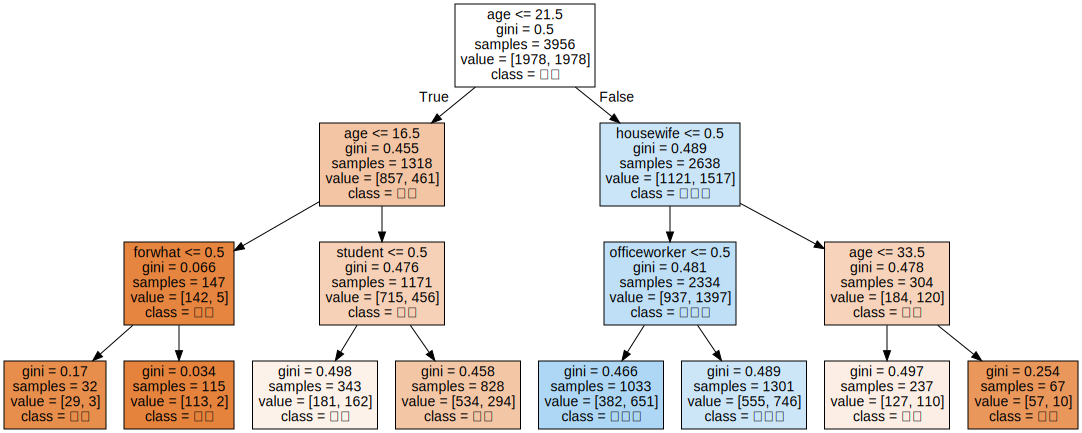

In [ ]:
#시각화
from sklearn.tree import export_graphviz
import graphviz

#파일 생성
export_graphviz(DT_model,out_file = "tree.dot",class_names=["식품","비식품"],
                feature_names = feature_name, impurity=True, filled=True)

#파일 열기
with open("tree.dot",encoding="utf-8") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

##그래디언트 부스트

In [ ]:
#1.변수선택
X = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]
Y = df["class"]
#2. train-test split
X_train,X_test, Y_train,Y_test= train_test_split(X,Y,test_size=0.3, random_state=0)

#3.데이터 전처리(preprocessing)
ct=ColumnTransformer([("scaling",StandardScaler(),['age',]),
                    ("onehot", OneHotEncoder(sparse=False),['Diet_experience','student','officeworker','forwhat','married','housewife'])])

ct.fit(X_train)
ct.transform(X_train)
X_train = ct.transform(X_train)
X_test= ct.transform(X_test)

#4.오버샘플링
smote=SMOTE(random_state=0)
X_train,Y_train=smote.fit_resample(X_train,Y_train)#5. 모형 생성
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier(random_state=0, n_estimators=100, max_depth=4,
                                 learning_rate=0.1)

#6.모형 학습 예측
model.fit(X_train,Y_train)
Y_pred=model.predict(X_test)
print("Y_pred value: \n", Y_pred)
print("accuracy(test):{:.3f}".format(model.score(X_test,Y_test)))
print(classification_report(Y_test,Y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Y_pred value: 
 [0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1
 1 1 0 0 

##인공신경망

In [ ]:
#1.변수선택
X = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]
Y = df["class"]
#2. train-test split
X_train,X_test, Y_train,Y_test= train_test_split(X,Y,test_size=0.3, random_state=0)

#3.데이터 전처리(preprocessing)
ct=ColumnTransformer([("scaling",StandardScaler(),['age']),
                    ("onehot", OneHotEncoder(sparse=False),['Diet_experience','student','officeworker','forwhat','married','housewife'])])

ct.fit(X_train)
ct.transform(X_train)
X_train = ct.transform(X_train)
X_test= ct.transform(X_test)

#4.오버샘플링
smote=SMOTE(random_state=0)
X_train,Y_train=smote.fit_resample(X_train,Y_train)
#5.모델링
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(random_state=0, alpha=0.001,hidden_layer_sizes=[50])
#5-1 모형학습
nn_model.fit(X_train,Y_train)

#예측
Y_pred= nn_model.predict(X_test)
#7.결과값 보고
print("Y 예측값 \n",Y_pred)
print("accuracy(train) : {:.3f}".format(nn_model.score(X_train,Y_train)))
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Y 예측값 
 [0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0
 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1
 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1
 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1
 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1
 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1
 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0
 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1
 1 1 0 0 0 1 1 0 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## ML(로지스틱, SVM, NB)

선형회귀(로지스틱회귀)

In [ ]:
#데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)

#oversampling
smote = SMOTE(random_state=0)
X_train_over, Y_train_over = smote.fit_resample(X_train, Y_train)

[[ 1.27000159  0.56243433 -0.82556161 ...  0.83153955  2.22157613
  -0.32299678]
 [-1.14318153  0.56243433  1.21129663 ...  0.83153955 -0.45013087
  -0.32299678]
 [ 1.27000159  0.56243433 -0.82556161 ...  0.83153955  2.22157613
   3.09600605]
 ...
 [-0.10896019  0.56243433  1.21129663 ...  0.83153955 -0.45013087
  -0.32299678]
 [-1.48792197  0.56243433  1.21129663 ... -1.20258862 -0.45013087
  -0.32299678]
 [ 3.16607404  0.56243433 -0.82556161 ... -1.20258862  2.22157613
  -0.32299678]]


In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C = 1, random_state = 0)

logit.fit(X_train_over, Y_train_over)
Y_pred = logit.predict(X_test)

#Y_pred
print("R2 : {:.3f}".format(logit.score(X_train_over, Y_train_over)))

from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))
print(logit.intercept_)
print(logit.coef_)

R2 : 0.575
              precision    recall  f1-score   support

           0       0.91      0.58      0.71       841
           1       0.22      0.68      0.33       144

    accuracy                           0.60       985
   macro avg       0.57      0.63      0.52       985
weighted avg       0.81      0.60      0.66       985

[-0.05565711]
[[ 0.20531214  0.1846765  -0.17762986  0.04083564 -0.03705188  0.04748327
  -0.15375816]]


SVM(서포트벡터머신)

In [ ]:
from sklearn.metrics import classification_report
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

smote = SMOTE(random_state=0)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

from sklearn.svm import SVC

#C값:?
#gamma:?
SVC_model = SVC(C=1, random_state = 0)
SVC_model.fit(X_train, Y_train)
Y_pred = SVC_model.predict(X_test)
print("accuracy : {:.3f}".format(SVC_model.score(X_train, Y_train)))
print(classification_report(Y_test, Y_pred))

accuracy : 0.602
              precision    recall  f1-score   support

           0       0.92      0.47      0.62       841
           1       0.20      0.76      0.31       144

    accuracy                           0.51       985
   macro avg       0.56      0.62      0.47       985
weighted avg       0.81      0.51      0.58       985



나이브베이즈

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

smote = SMOTE(random_state = 0)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

from sklearn.naive_bayes import GaussianNB

NB_model = GaussianNB(var_smoothing = 0)
NB_model.fit(X_train, Y_train)
Y_pred = NB_model.predict(X_test)
print("accuracy : {:.3f}".format(NB_model.score(X_train, Y_train)))
print(classification_report(Y_test, Y_pred))

accuracy : 0.593
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       841
           1       0.21      0.69      0.32       144

    accuracy                           0.57       985
   macro avg       0.56      0.62      0.51       985
weighted avg       0.81      0.57      0.64       985



##모델 성능 비교

In [ ]:
df.columns

Index(['age', 'sex', 'height', 'married', 'bmi', 'Diet_experience', 'student',
       'housewife', 'officeworker', 'forwhat', 'class'],
      dtype='object')

In [ ]:
X1 = df[['age','Diet_experience','student','officeworker','forwhat','married','housewife']]
Y1 = df["class"]

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X1,Y1,test_size=0.3,random_state=0)

#Column transform
ct = ColumnTransformer([("scaling",StandardScaler(),['age']),
                        ("onehot",OneHotEncoder(sparse=False),['Diet_experience','student','officeworker','forwhat','married','housewife'])])

ct.fit(X_train)
X_train=ct.transform(X_train)
X_test=ct.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
logit_model=LogisticRegression(C=1,random_state=0)
knn_model = KNeighborsClassifier(n_neighbors=9)
dt_model = DecisionTreeClassifier(random_state=0,max_depth=3)

In [ ]:
logit_model.fit(X_train,Y_train)
knn_model.fit(X_train,Y_train)
dt_model.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [ ]:
logit_Y_pred = logit_model.predict(X_test)
knn_Y_pred = knn_model.predict(X_test)
dt_Y_pred = dt_model.predict(X_test)

In [ ]:
print("logit score : {:.3f}".format(logit_model.score(X_train,Y_train)))
print("knn score : {:.3f}".format(knn_model.score(X_train,Y_train)))
print("dt score : {:.3f}".format(dt_model.score(X_train,Y_train)))

logit score : 0.861
knn score : 0.861
dt score : 0.861


In [ ]:
print(classification_report(Y_test,logit_Y_pred))
print(classification_report(Y_test,knn_Y_pred))
print(classification_report(Y_test,dt_Y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       841
           1       0.00      0.00      0.00       144

    accuracy                           0.85       985
   macro avg       0.43      0.50      0.46       985
weighted avg       0.73      0.85      0.79       985

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       841
           1       0.22      0.01      0.03       144

    accuracy                           0.85       985
   macro avg       0.54      0.50      0.47       985
weighted avg       0.76      0.85      0.79       985

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       841
           1       0.00      0.00      0.00       144

    accuracy                           0.85       985
   macro avg       0.43      0.50      0.46       985
weighted avg       0.73      0.85      0.79       985



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

In [ ]:
#plot

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

fpr1, tpr1, threshold = roc_curve(Y_test, logit_model.decision_function(X_test))
fpr2, tpr2, threshold = roc_curve(Y_test, knn_model.predict_proba(X_test)[:,1])
fpr3, tpr3, threshold = roc_curve(Y_test, dt_model.predict_proba(X_test)[:,1])

#ROC
plt.plot(fpr1,tpr1, 'o-', ms=2, label = "logit")
plt.plot(fpr2,tpr2, 'o-', ms=2, label = "knn")
plt.plot(fpr3,tpr3, 'o-', ms=2, label = "dt")
plt.plot([0,1],[0,1], "k--", label = "random guess")

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC")
plt.show()

In [ ]:
logit_model_auc = roc_auc_score(Y_test, logit_model.decision_function(X_test))
knn_model_auc = roc_auc_score(Y_test, knn_model.predict_proba(X_test)[:,1])
dt_model_auc = roc_auc_score(Y_test, dt_model.predict_proba(X_test)[:,1])

In [ ]:
print("logit AUC score: {:.3f}".format(logit_model_auc))
print("knn AUC score: {:.3f}".format(knn_model_auc))
print("dt AUC score: {:.3f}".format(dt_model_auc))

logit AUC score: 0.670
knn AUC score: 0.565
dt AUC score: 0.640
